In [1]:
import os
import time
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime
from model_settings import ms
from df_collector import df_collector
pd.set_option("display.max_columns",None)
pd.options.display.float_format = '{:.5f}'.format
root = Path().resolve().parent.parent
df_collector.root = root
models_dir = os.path.join(root,ms.trained_models)
train_start = time.time()
train_start_datetime = datetime.fromtimestamp(train_start)
train_start_tag = train_start_datetime.strftime('%c')
print("\n"+"#"*18+"\n# training start #\n"+
      "#"*18+"\n"+f"\n{train_start_tag}")


##################
# training start #
##################

Fri Nov  8 15:00:14 2024


In [2]:
data = df_collector.cboe_spx_asians().iloc[:,1:]
pricename = [f for f in data.columns if f.find('_price')!=-1 and f.find('spot_')==-1 and f.find('strike_')==-1][0]
filetag = f'cboe spx {pricename[:pricename.find('_',0)]}'
og_count = data.shape[0]
print(f'collected {pricename[:pricename.find('_',0)]} options')
data

collected asian options


,spot_price,strike_price,days_to_maturity,n_fixings,fixing_frequency,past_fixings,averaging_type,w,risk_free_rate,dividend_rate,calculation_date,kappa,theta,rho,eta,v0,date,asian_price
0,3944.00000,1972.00000,7,1.00000,7,0,geometric,call,0.00053,0.01480,2021-03-23 14:07:30.269,0.99120,0.06723,-1.00000,0.23681,0.02271,2021-03-23,1971.09433
1,3944.00000,1972.00000,7,1.00000,7,0,geometric,put,0.00053,0.01480,2021-03-23 14:07:30.269,0.99120,0.06723,-1.00000,0.23681,0.02271,2021-03-23,0.00000
2,3944.00000,1972.00000,7,1.00000,7,0,arithmetic,call,0.00053,0.01480,2021-03-23 14:07:30.269,0.99120,0.06723,-1.00000,0.23681,0.02271,2021-03-23,1971.23633
3,3944.00000,1972.00000,7,1.00000,7,0,arithmetic,put,0.00053,0.01480,2021-03-23 14:07:30.269,0.99120,0.06723,-1.00000,0.23681,0.02271,2021-03-23,0.00000
4,3944.00000,2958.00000,7,1.00000,7,0,geometric,call,0.00053,0.01480,2021-03-23 14:07:30.269,0.99120,0.06723,-1.00000,0.23681,0.02271,2021-03-23,985.10439
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91795,5857.00000,7320.75000,84,1.00000,84,0,arithmetic,put,0.04181,0.01269,2024-10-14 15:26:27.717,4.06705,0.00000,-0.71781,1.48700,0.12159,2024-10-14,1429.79509
91796,5857.00000,8785.00000,84,1.00000,84,0,geometric,call,0.04181,0.01269,2024-10-14 15:26:27.717,4.06705,0.00000,-0.71781,1.48700,0.12159,2024-10-14,0.00000
91797,5857.00000,8785.00000,84,1.00000,84,0,geometric,put,0.04181,0.01269,2024-10-14 15:26:27.717,4.06705,0.00000,-0.71781,1.48700,0.12159,2024-10-14,2887.93407
91798,5857.00000,8785.00000,84,1.00000,84,0,arithmetic,call,0.04181,0.01269,2024-10-14 15:26:27.717,4.06705,0.00000,-0.71781,1.48700,0.12159,2024-10-14,0.00000


In [3]:
pd.Series(np.random.normal(scale=0.002,size=10000)).describe()

count   10000.00000
mean        0.00003
std         0.00201
min        -0.00798
25%        -0.00130
50%         0.00003
75%         0.00136
max         0.00771
dtype: float64

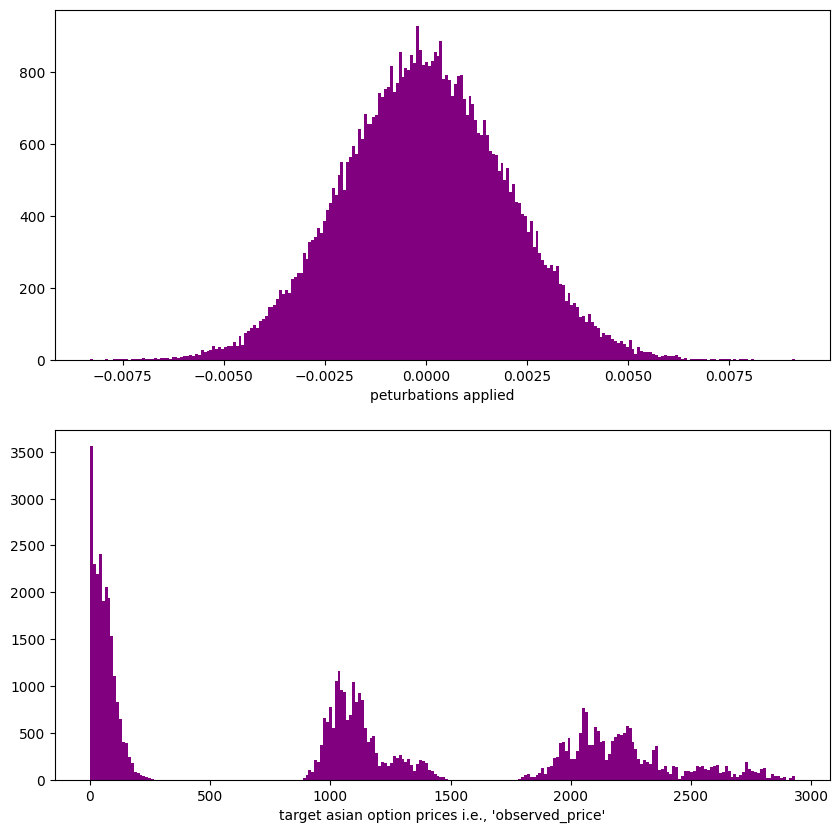

total data count: 58710
count   58710.00000
mean     1066.35460
std       907.44295
min         0.38952
25%        74.56206
50%      1060.58528
75%      2039.01124
max      2931.60143
Name: observed_price, dtype: float64


In [4]:
data = data[data[pricename]<=data['spot_price']]
data = data[data[pricename]>=0.01].copy()
data['observed_price'] = data[pricename]+np.random.normal(scale=0.002,size=data.shape[0])
data = data[data['observed_price']>=data['spot_price']*0.0001].copy()
p = data[pricename]-data['observed_price']
plotprices = data['observed_price']

fig,axs = plt.subplots(2,figsize=(10,10))
axs[0].hist(p,bins=int(len(p)**0.5),color='purple')
axs[0].set_xlabel('peturbations applied')
axs[1].hist(plotprices,bins=int(len(plotprices)**0.5),color='purple')
axs[1].set_xlabel(f"target {pricename[:pricename.find('_')]} option prices i.e., 'observed_price'")
plt.show()
print(f"total data count: {data.shape[0]}")
print(data['observed_price'].describe())

# training procedure

In [5]:
pricename

'asian_price'

In [6]:
from convsklearn import convsklearn
trainer = convsklearn()
help(trainer)
print('instance variables:')
trainer.__dict__

Help on convsklearn in module convsklearn.convsklearn object:

class convsklearn(builtins.object)
 |  convsklearn(target_name='observed_price', excluded_features=['barrier_price', 'asian_price', 'observed_price', 'outin', 'updown', 'n_fixings'], seed=1312)
 |
 |  a proprietary class of convenience wrappers for sklearn
 |
 |  Methods defined here:
 |
 |  __init__(self, target_name='observed_price', excluded_features=['barrier_price', 'asian_price', 'observed_price', 'outin', 'updown', 'n_fixings'], seed=1312)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |
 |  load_data(self, data)
 |
 |  preprocess_data(self, development_dates, test_dates, plot=True)
 |
 |  run_dnn(self, print_details=True)
 |
 |  test_prediction_accuracy(self)
 |
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |
 |  __dict__
 |      dictionary for instance variables
 |
 |  __weakref__
 |      list of weak references to the object


{'seed': 1312,
 'raw_data': Empty DataFrame
 Columns: []
 Index: [],
 'dataset': Empty DataFrame
 Columns: []
 Index: [],
 'target_name': 'observed_price',
 'excluded_features': ['barrier_price',
  'asian_price',
  'observed_price',
  'outin',
  'updown',
  'n_fixings'],
 'numerical_features': [],
 'categorical_features': [],
 'feature_set': [],
 'n_features': 0,
 'development_dates': {},
 'test_dates': {},
 'train_data': {},
 'test_data': {},
 'train_X': {},
 'train_y': {},
 'test_X': {},
 'test_y': {},
 'preprocessor': None,
 'pipeline': None,
 'model': None,
 'model_fit': None,
 'dnn_runtime': 0,
 'numerical_scaler': StandardScaler()}

In [7]:
trainer.raw_data

""


In [8]:
trainer.load_data(data)
trainer.__dict__
trainer.dataset

,spot_price,strike_price,days_to_maturity,n_fixings,fixing_frequency,past_fixings,averaging_type,w,risk_free_rate,dividend_rate,calculation_date,kappa,theta,rho,eta,v0,date,asian_price,observed_price
0,3944.00000,1972.00000,7,1.00000,7,0,geometric,call,0.00053,0.01480,2021-03-23 14:07:30.269,0.99120,0.06723,-1.00000,0.23681,0.02271,2021-03-23,1971.09433,1971.09246
2,3944.00000,1972.00000,7,1.00000,7,0,arithmetic,call,0.00053,0.01480,2021-03-23 14:07:30.269,0.99120,0.06723,-1.00000,0.23681,0.02271,2021-03-23,1971.23633,1971.23363
4,3944.00000,2958.00000,7,1.00000,7,0,geometric,call,0.00053,0.01480,2021-03-23 14:07:30.269,0.99120,0.06723,-1.00000,0.23681,0.02271,2021-03-23,985.10439,985.10767
6,3944.00000,2958.00000,7,1.00000,7,0,arithmetic,call,0.00053,0.01480,2021-03-23 14:07:30.269,0.99120,0.06723,-1.00000,0.23681,0.02271,2021-03-23,985.24639,985.24511
8,3944.00000,3944.00000,7,1.00000,7,0,geometric,call,0.00053,0.01480,2021-03-23 14:07:30.269,0.99120,0.06723,-1.00000,0.23681,0.02271,2021-03-23,20.57226,20.57133
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91791,5857.00000,5856.50000,84,1.00000,84,0,arithmetic,put,0.04181,0.01269,2024-10-14 15:26:27.717,4.06705,0.00000,-0.71781,1.48700,0.12159,2024-10-14,176.72445,176.72565
91793,5857.00000,7320.75000,84,1.00000,84,0,geometric,put,0.04181,0.01269,2024-10-14 15:26:27.717,4.06705,0.00000,-0.71781,1.48700,0.12159,2024-10-14,1437.72795,1437.72736
91795,5857.00000,7320.75000,84,1.00000,84,0,arithmetic,put,0.04181,0.01269,2024-10-14 15:26:27.717,4.06705,0.00000,-0.71781,1.48700,0.12159,2024-10-14,1429.79509,1429.79558
91797,5857.00000,8785.00000,84,1.00000,84,0,geometric,put,0.04181,0.01269,2024-10-14 15:26:27.717,4.06705,0.00000,-0.71781,1.48700,0.12159,2024-10-14,2887.93407,2887.93486


## preprocessing

In [9]:
dates = pd.Series(np.sort(data['date'].unique()))
dates

0      2021-03-23
1      2021-03-29
2      2021-03-31
3      2021-04-07
4      2021-04-09
          ...    
374    2024-09-24
375    2024-10-07
376    2024-10-08
377    2024-10-09
378    2024-10-14
Length: 379, dtype: object

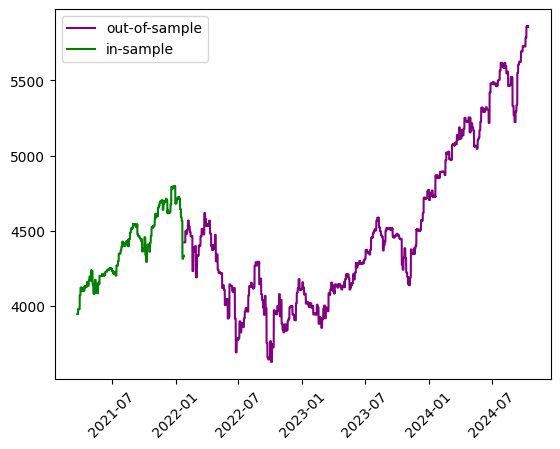

In [10]:
development_dates = dates[:len(dates)//4]
test_dates = dates[~dates.isin(development_dates)]
trainer.preprocess_data(development_dates,test_dates)

## training

In [11]:
trainer.run_dnn()


training on 15538 samples...

alpha: 0.01
hidden_layer_sizes: (14, 14)
learning_rate: adaptive
learning_rate_init: 0.1
solver: sgd
early_stopping: False
max_iter: 500
warm_start: True
tol: 0.0001
random_state: 1312
cpu: 2.146219491958618


In [12]:
print('instance varianbles:')
trainer.__dict__

instance varianbles:


{'seed': 1312,
 'raw_data':        spot_price  strike_price  days_to_maturity  n_fixings  \
 0      3944.00000    1972.00000                 7    1.00000   
 2      3944.00000    1972.00000                 7    1.00000   
 4      3944.00000    2958.00000                 7    1.00000   
 6      3944.00000    2958.00000                 7    1.00000   
 8      3944.00000    3944.00000                 7    1.00000   
 ...           ...           ...               ...        ...   
 91791  5857.00000    5856.50000                84    1.00000   
 91793  5857.00000    7320.75000                84    1.00000   
 91795  5857.00000    7320.75000                84    1.00000   
 91797  5857.00000    8785.00000                84    1.00000   
 91799  5857.00000    8785.00000                84    1.00000   
 
        fixing_frequency  past_fixings averaging_type     w  risk_free_rate  \
 0                     7             0      geometric  call         0.00053   
 2                     7         

In [13]:
trainer.model_fit

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      ColumnTransformer(transformers=[('StandardScaler',
                                                                                       StandardScaler(),
                                                                                       ['spot_price',
                                                                                        'strike_price',
                                                                                        'days_to_maturity',
                                                                                        'fixing_frequency',
                                                                                        'past_fixings',
                                                                                        'risk_free_rate',
                                                                                        'dividend_rate',
                                                                                        'kappa',
                                                                                        'theta',
                                                                                        'rho',
                                                                                        'eta',
                                                                                        'v0']),
                                                                                      ('OneHotEncoder',
                                                                                       OneHotEncoder(sparse_output=False),
                                                                                       ['averaging_type',
                                                                                        'w'])])),
                                                     ('regressor',
                                                      MLPRegressor(alpha=0.01,
                                                                   hidden_layer_sizes=(14,
                                                                                       14),
                                                                   learning_rate='adaptive',
                                                                   learning_rate_init=0.1,
                                                                   max_iter=500,
                                                                   random_state=1312,
                                                                   solver='sgd',
                                                                   warm_start=True))]),
                           transformer=StandardScaler())

### initial test

In [14]:
train_test = trainer.test_prediction_accuracy()


in sample:
     RMSE: 12.092293102261952
     MAE: 7.413614465246619

out of sample:
     RMSE: 315.9337610519383
     MAE: 237.0845198509429


In [15]:
oserr = trainer.test_data['outofsample_error']
iserr = trainer.train_data['insample_error']

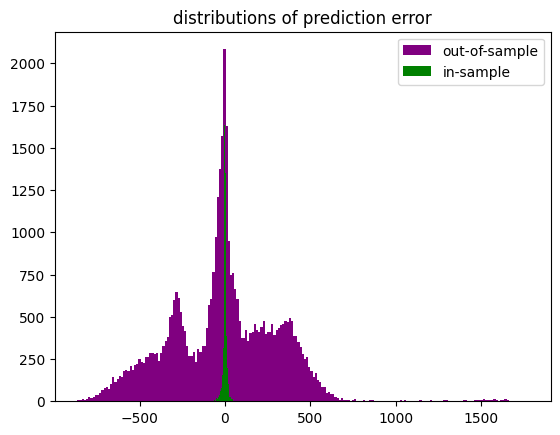

In [16]:
plt.figure()
plt.hist(oserr,color='purple',label='out-of-sample',bins=int(np.sqrt(len(oserr))))
plt.hist(iserr,color='green',label='in-sample',bins=int(np.sqrt(len(iserr))))
plt.legend()
plt.title('distributions of prediction error')
plt.show()

## saving

In [17]:
train_end = time.time()
train_end_tag = str(datetime.fromtimestamp(
    train_end).strftime("%Y_%m_%d %H%M%S%f"))
file_tag = str(train_end_tag + " " + filetag)
files_dir = os.path.join(models_dir,file_tag)

def save_model():
    if Path(files_dir).exists():
        pass
    else:
        os.mkdir(files_dir)
    file_dir = os.path.join(files_dir,file_tag)
    joblib.dump(trainer.__dict__,str(f"{file_dir}.pkl"))
    pd.set_option("display.max_columns",None)
    print(f"model saved to {file_dir}")

print(f"execute the command 'save_model()' to save the following model: {file_tag}")
train_runtime = train_end-train_start
print(f"\ncpu: {train_runtime}")

execute the command 'save_model()' to save the following model: 2024_11_08 150019087850 cboe spx asian

cpu: 4.634666442871094


In [18]:
trainer.model_fit

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      ColumnTransformer(transformers=[('StandardScaler',
                                                                                       StandardScaler(),
                                                                                       ['spot_price',
                                                                                        'strike_price',
                                                                                        'days_to_maturity',
                                                                                        'fixing_frequency',
                                                                                        'past_fixings',
                                                                                        'risk_free_rate',
                                                                                        'dividend_rate',
                                                                                        'kappa',
                                                                                        'theta',
                                                                                        'rho',
                                                                                        'eta',
                                                                                        'v0']),
                                                                                      ('OneHotEncoder',
                                                                                       OneHotEncoder(sparse_output=False),
                                                                                       ['averaging_type',
                                                                                        'w'])])),
                                                     ('regressor',
                                                      MLPRegressor(alpha=0.01,
                                                                   hidden_layer_sizes=(14,
                                                                                       14),
                                                                   learning_rate='adaptive',
                                                                   learning_rate_init=0.1,
                                                                   max_iter=500,
                                                                   random_state=1312,
                                                                   solver='sgd',
                                                                   warm_start=True))]),
                           transformer=StandardScaler())